<h3 align="center"><img src="data/subway_logo.jpg" width="400" height="25">

<h3 align="center"> Supply Chain and Logistics, Imperial College Business School</h3> 
<h3 align="center"> Demand Forecasting for a Fast Food Restaurant</h3> 
<h3 align="center"> CID: 02005361 </h3> 

# Introduction
This assignment is tasked with forecasting how much lettuce should be procured for a fast food restaurant, Subway, in Berkeley California, USA. The data available contains records of over 7,000 orders placed between 15th March 2015 and 15th June 2015, at store 46673. The data tables of interest to us are tables 1 and 2 for order information, tables 4, 5, 6, and 7 for recipe information, tables 8 and 9 for subrecipe information, and tables 10 and 11 for ingredients. Using this dataset our objective is to calculate a forecast of the demand for lettuce over the following two weeks, June 16-29th 2015, using the ARIMA model and the Holt-Winters model.

<h3 align="center"><img src="data/subway_menu.jpg" width="500" height="25">

# Data Import & Prep

In [1]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from decimal import Decimal
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error

C:\Users\tsymonds\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\tsymonds\Anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [2]:
# import tables
filelist = ('data/1_pos_ordersale.csv', 'data/2_menuitem.csv', 'data/3_store_restaurant.csv', 'data/4_menu_items.csv', 'data/5_recipes.csv', 'data/6_recipe_ingredient_assignments.csv', 'data/7_recipe_sub_recipe_assignments.csv', 'data/8_sub_recipes.csv', 'data/9_sub_recipe_ingr_assignments.csv', 'data/10_ingredients.csv', 'data/11_portion_uom_types.csv')
for filename in filelist:
    table1 = pd.read_csv(filelist[0], parse_dates = True)
    table2 = pd.read_csv(filelist[1], parse_dates = True)
    table3 = pd.read_csv(filelist[2])
    table4 = pd.read_csv(filelist[3])
    table5 = pd.read_csv(filelist[4])
    table6 = pd.read_csv(filelist[5])
    table7 = pd.read_csv(filelist[6])
    table8 = pd.read_csv(filelist[7])
    table9 = pd.read_csv(filelist[8])
    table10 = pd.read_csv(filelist[9])
    table11 = pd.read_csv(filelist[10])
    
#Filter data for Store ID 46673
orders = table1[table1['StoreNumber'] == 46673]

# Check for duplicates
orders_dupes = orders[orders.duplicated(keep=False)]
if orders_dupes.empty:
    print('No duplicate records.')

No duplicate records.


In [3]:
#####################
###### COMBINE ######
#####################
# Merge combine on unique order sale key, MenuItemID, RecipeID
merge2 = pd.merge(table2, orders, on=['MD5KEY_ORDERSALE', 'StoreNumber'])
merge4 = pd.merge(table4, merge2, left_on='MenuItemId', right_on='Id')
merge5 = pd.merge(merge4, table5, on='RecipeId')
# Tabulate lettuce attributes
lettuce_10_table = table10[table10['IngredientName'].str.contains('lettuce', case=False, na=False)]
# Merge combine on IngredientID
lettuce_6_table = pd.merge(table6, lettuce_10_table, on='IngredientId')

########################
##### CALCULATIONS #####
########################
# Calculate lettuce consumption from recipes
recipe_lettuce_consumption = pd.merge(merge5, lettuce_6_table, on='RecipeId')
recipe_lettuce_consumption['TotalQuantity'] = (recipe_lettuce_consumption['Quantity_x'].fillna(0) * recipe_lettuce_consumption['Quantity_y'].fillna(0))
# Calculate lettuce consumption from subrecipes
sub_recipe_table = pd.merge(table7, table8, on='SubRecipeId')
sub_recipe_ingredients = pd.merge(sub_recipe_table, table9, on='SubRecipeId')
#Join with recipe_details for quanitities
subrecipe_lettuce_consumption = pd.merge(sub_recipe_ingredients, lettuce_10_table, on='IngredientId')
subrecipe_lettuce_consumption['Factor'].fillna(0)  
subrecipe_lettuce_consumption['Quantity'].fillna(0) 
# Merge subrecipe with recipe
subrecipe_lettuce_consumption = pd.merge(subrecipe_lettuce_consumption, merge5[['RecipeId', 'date_x']], on='RecipeId', how='left')                         
#Set missing quantity and factor values to 0
subrecipe_lettuce_consumption['Quantity'] = subrecipe_lettuce_consumption['Quantity'].fillna(0)
subrecipe_lettuce_consumption['Factor'] = subrecipe_lettuce_consumption['Factor'].fillna(0)
subrecipe_lettuce_consumption = subrecipe_lettuce_consumption.dropna(subset=['date_x'])
recipe_lettuce_consumption['Quantity_x'] = recipe_lettuce_consumption['Quantity_x'].apply(Decimal)
recipe_lettuce_consumption['Quantity_y'] = recipe_lettuce_consumption['Quantity_y'].apply(Decimal)
subrecipe_lettuce_consumption['TotalQuantity'] = subrecipe_lettuce_consumption['Quantity'] * subrecipe_lettuce_consumption['Factor']
print("Lettuce demand calculations complete.")

####################
##### TABULATE #####
####################
# Combine recipe and subrecipe consumption
recipe_lettuce_consumption_x = recipe_lettuce_consumption[['date_x', 'TotalQuantity']]
recipe_lettuce_consumption_x = recipe_lettuce_consumption_x.rename(columns={'date_x': 'TransactionDate'})
subrecipe_lettuce_consumption = subrecipe_lettuce_consumption[['date_x', 'TotalQuantity']]
subrecipe_lettuce_consumption = subrecipe_lettuce_consumption.rename(columns={'date_x': 'TransactionDate'})
lettuce_demand = pd.concat([recipe_lettuce_consumption_x, subrecipe_lettuce_consumption], ignore_index=True)
# Convert date column to datetime
date_format='%y-%m-%d'
lettuce_demand['TransactionDate'] = pd.to_datetime(lettuce_demand['TransactionDate'], format= date_format, errors='coerce')                    
invalid_dates = lettuce_demand[lettuce_demand['TransactionDate'].isna()]
# Group by date
daily_lettuce_demand = lettuce_demand.groupby('TransactionDate')['TotalQuantity'].sum()
daily_lettuce_demand = daily_lettuce_demand.reset_index()
daily_lettuce_demand.rename(columns={'TotalQuantity': 'Qty (oz)', 'TransactionDate': 'date'}, inplace=True)
daily_lettuce_demand_copy = daily_lettuce_demand.copy()
# Add column for Monday-Sunday date
daily_lettuce_demand['Day'] = daily_lettuce_demand['date'].dt.day_name()

########################
###### DAILY SETS ######
#######################
# Create datatsets for each day to perform weekly seasonality analysis
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
def days_dataframes(df, day):
    day_df = daily_lettuce_demand[df['Day']==day]
    return day_df
mon_df = days_dataframes(daily_lettuce_demand, 'Monday')
tue_df = days_dataframes(daily_lettuce_demand, 'Tuesday')
wed_df = days_dataframes(daily_lettuce_demand, 'Wednesday')
thu_df = days_dataframes(daily_lettuce_demand, 'Thursday')
fri_df = days_dataframes(daily_lettuce_demand, 'Friday')
sat_df = days_dataframes(daily_lettuce_demand, 'Saturday')
sun_df = days_dataframes(daily_lettuce_demand, 'Sunday')
print("Median lettuce (oz) on Mondays: " + str(int(mon_df['Qty (oz)'].median())))
print("Median lettuce (oz) on Tuedays: " + str(int(tue_df['Qty (oz)'].median())))
print("Median lettuce (oz) on Wednesdays: " + str(int(wed_df['Qty (oz)'].median())))
print("Median lettuce (oz) on Thursdays: " + str(int(thu_df['Qty (oz)'].median())))
print("Median lettuce (oz) on Fridays: " + str(int(fri_df['Qty (oz)'].median())))
print("Median lettuce (oz) on Saturdays: " + str(int(sat_df['Qty (oz)'].median())))
print("Median lettuce (oz) on Sundays: " + str(int(sun_df['Qty (oz)'].median())))

####################
##### OUTLIERS #####
####################
# Check for outliers by day and replace with median
def day_outlier_check(df, col, new_col, standard_deviations):
    # Calculate z-scores
    df[new_col] = (df[col] - df[col].mean()) / df[col].std()
    # Calculate median
    median_quantity = df[col].median()
    # Replace outliers (z_score > abs(2)) with the median
    df2 = df
    df2[col] = df2.apply(lambda row: median_quantity if row['z_score'] > 2 or row['z_score'] < -2 else row[col], axis=1)
    return df2
mon_df_clean = day_outlier_check(mon_df, 'Qty (oz)', 'z_score', 2)
tue_df_clean = day_outlier_check(tue_df, 'Qty (oz)', 'z_score', 2)
wed_df_clean = day_outlier_check(wed_df, 'Qty (oz)', 'z_score', 2)
thu_df_clean = day_outlier_check(thu_df, 'Qty (oz)', 'z_score', 2)
fri_df_clean = day_outlier_check(fri_df, 'Qty (oz)', 'z_score', 2)
sat_df_clean = day_outlier_check(sat_df, 'Qty (oz)', 'z_score', 2)
sun_df_clean = day_outlier_check(sun_df, 'Qty (oz)', 'z_score', 2)

##################
##### OUTPUT #####
##################
# Prepare final data for analysis
daily_dfs = [mon_df_clean, tue_df_clean, wed_df_clean, thu_df_clean, fri_df_clean, sat_df_clean, sun_df_clean]
output = pd.concat(daily_dfs)
output = output.drop('z_score', axis=1)
output = output.sort_values(by='date')



Lettuce demand calculations complete.
Median lettuce (oz) on Mondays: 174
Median lettuce (oz) on Tuedays: 154
Median lettuce (oz) on Wednesdays: 167
Median lettuce (oz) on Thursdays: 165
Median lettuce (oz) on Fridays: 94
Median lettuce (oz) on Saturdays: 74
Median lettuce (oz) on Sundays: 164


C:\Users\tsymonds\AppData\Local\Temp/ipykernel_13848/636260757.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[new_col] = (df[col] - df[col].mean()) / df[col].std()
C:\Users\tsymonds\AppData\Local\Temp/ipykernel_13848/636260757.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[col] = df2.apply(lambda row: median_quantity if row['z_score'] > 2 or row['z_score'] < -2 else row[col], axis=1)
C:\Users\tsymonds\AppData\Local\Temp/ipykernel_13848/636260757.py:87: SettingWithCopyWarning: 
A value is 

-------------------------------------------------------------------------------------------------------------------------------

# Timeseries of Lettuce Consumed from March-June 2015 (oz)

Text(0.5, 1.0, 'Daily Lettuce Consumption (oz) in Q2 2015')

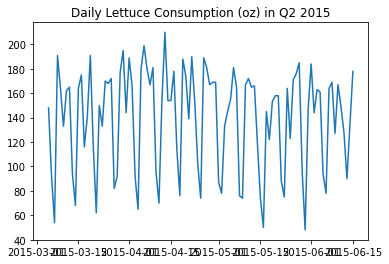

In [4]:
# timeseries graph 
my_array_x = output[['Qty (oz)']].to_numpy()
my_array_y = output[['date']].to_numpy()
plt.plot(my_array_y, my_array_x)
plt.title('Daily Lettuce Consumption (oz) in Q2 2015')

-------------------------------------------------------------------------------------------------------------------------------

# ARIMA Analysis

The Autoregressive Integrated Moving Average (ARIMA) forecasting model utilizies autoregressive and moving average components and is a flexible kind of model that can be applied to a broad set of case problems and industries. There are three parameters that we need to pay attention to for this model: p, the count of lagged observations, q, the moving average, and d, the differentiation. We can identify these parameters through the three methods below.

### Stationarity

In [5]:
# create array of consumption
lettuce_data_Q2_2015 = output
lettuce_data_Q2_2015['date'] = pd.to_datetime(lettuce_data_Q2_2015['date'])
lettuce_data_Q2_2015.set_index('date', inplace=True)
lettuce_array = lettuce_data_Q2_2015['Qty (oz)']

In [6]:
# check for stationarity
stationary = output
result = adfuller(stationary["Qty (oz)"])
stationarity_interpretation = "Stationary" if result[1] < 0.05 else "Non-Stationary"
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
print(f"Interpretation: The series is {stationarity_interpretation}.")

ADF Statistic: -2.242017815518828
p-value: 0.19135022390069556
Interpretation: The series is Non-Stationary.


##### Observations:
We do not have stationarity, which we also could have inferred from the timeseries graph showing a vast discrepancy on a given day. But this check gives us the evidence to estimate our model where d=1. If we did find there to be stationarity, we would have set d=0.

### Autocorrelation Function (ACF)

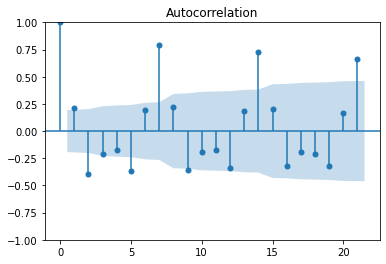

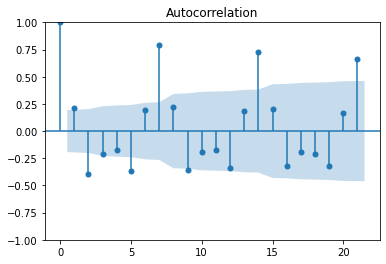

In [7]:
# plot chart
plot_acf(output["Qty (oz)"])

The ACF calculates the correlation between a time series and its lagged values, capturing the degree of similarity between a given time and the time minus lag. We run ACF to get the p parameter for our ARIMA model estimation. In practice, we must count the number of lags before a massive spike cutoff in the chart, and in this case we stop at the first lag, so p=1.

### Partial Autocorrelation Function (PACF)

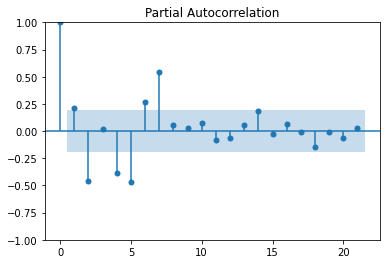

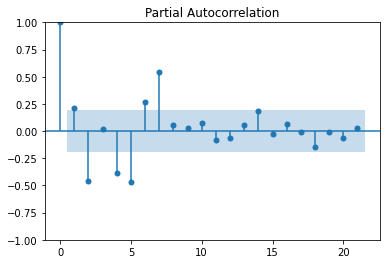

In [8]:
# plot chart
plot_pacf(output["Qty (oz)"])

The PACF accounts for the effects of all intermediate lags before calculating the correlation between a time series and its lagged values. We run PACF to get the q parameter for our ARIMA model estimation. Here we also stop at the first lag, so q=1.

### ARIMA Model

In [9]:
# Initial ARIMA Model parameters
p, d, q = 1, 1, 1
# Estimate the ARIMA model
arima_model = ARIMA(lettuce_array, order=(p, d, q))
# Fit the ARIMA model
arima_result = arima_model.fit()
print("BIC Model Fit: " + str(arima_result.bic))
# Forecast the ARIMA model
arima_forecast = arima_result.forecast(steps=14)
# final df
arima_df = pd.DataFrame({'Date':arima_forecast.index, 'ARIMA Forecast (oz)':arima_forecast.values})
print("ARIMA avg forecasted lettuce per day (oz): " + str (arima_df['ARIMA Forecast (oz)'].mean()))

# revised ARIMA Model parameters
p, d, q = 7, 1, 7
# Estimate the ARIMA model
rarima_model = ARIMA(lettuce_array, order=(p, d, q))
# Fit the ARIMA model
rarima_result = rarima_model.fit()
# Forecast the ARIMA model
rarima_forecast = rarima_result.forecast(steps=14)

arima_df

C:\Users\tsymonds\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\tsymonds\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\tsymonds\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


BIC Model Fit: 1062.7167106720797
ARIMA avg forecasted lettuce per day (oz): 140.59346942206795


C:\Users\tsymonds\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\tsymonds\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\tsymonds\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\tsymonds\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tsymonds\Anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimi

,Date,ARIMA Forecast (oz)
0,2015-06-16,148.482754
1,2015-06-17,141.767396
2,2015-06-18,140.239610
3,2015-06-19,139.892029
4,2015-06-20,139.812952
5,2015-06-21,139.794962
6,2015-06-22,139.790869
7,2015-06-23,139.789938
8,2015-06-24,139.789726
9,2015-06-25,139.789678


In [10]:
print("BIC Model Fit: " + str(arima_result.bic))
print("ARIMA avg forecasted lettuce per day (oz): " + str (arima_df['ARIMA Forecast (oz)'].mean()))

BIC Model Fit: 1062.7167106720797
ARIMA avg forecasted lettuce per day (oz): 140.59346942206795


-------------------------------------------------------------------------------------------------------------------------------

# Holt-Winters Analysis

Also known as triple exponential smoothing, which refers to the value level, trend, and seasonality behaviors of the time series. The major advantage of the Holts-Winter model over ARIMA is that it can account for seasonality, and does not need too much historical data to be accurate. For our weekly seasonality, we will need to estimate our model with the cadence of seasonality set at 7.

### Seasonality - lettuce consumption by day of the week (oz)

['Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday']
[95.4, 168.26666666666668, 70.26666666666667, 163.13333333333333, 164.0, 151.28571428571428, 167.92857142857142]


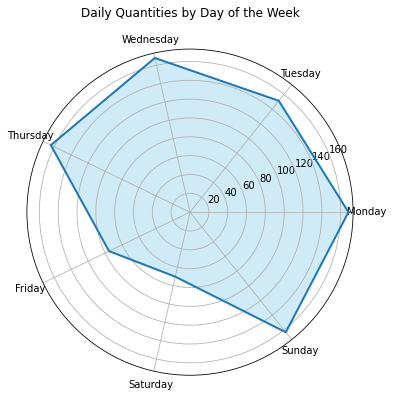

In [11]:
######################################
##### Day-of-the-week Polar Plot #####
######################################

# Calculate daily mean
df_dma = output.copy()
daily_mean_average = df_dma.groupby('Day')['Qty (oz)'].mean() 
daily_mean_list = list(daily_mean_average)

the_daily_list = []
the_daily_means = []
for i, v in daily_mean_average.items():
    the_daily_list.append(i)
    the_daily_means.append(v)
print(the_daily_list)
print(the_daily_means)

# set df
df = pd.DataFrame({'day_of_week': the_daily_list,'quantity': the_daily_means})
# order day of the week
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['day_of_week'] = pd.Categorical(df['day_of_week'], categories=day_order, ordered=True)
df = df.sort_values('day_of_week')
# convert day of the week into angles (7 days = 360 degrees)
angles = np.linspace(0, 2 * np.pi, len(df['day_of_week']), endpoint=False).tolist()
# Close loop on polar chart
quantities = df['quantity'].tolist()
quantities.append(quantities[0])  # Close the loop
angles.append(angles[0])  # Close the loop

# Plot the polar chart
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={'polar': True})
ax.plot(angles, quantities, linewidth=2, linestyle='solid', label='Quantity')
ax.fill(angles, quantities, color='skyblue', alpha=0.4)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(day_order)
ax.set_title('Daily Quantities by Day of the Week', y=1.08)

# Display the chart
plt.show()

##### Observations:
As suggested in our timeseries graph, we anticipated that there would be a difference in average lettuce consumption depending on the day. We can see in the polar chart above that there is a distinct decrease in average daily consumption on Fridays and Saturdays, whereas the demand on the other days or consistent. From this information we can gather that there is weekly seasonality to the demand of lettuce, and this will need to be taken into account in the Holt-Winters model.

### Holt-Winters Model

In [12]:
# Holt-Winters model
hw_model = ExponentialSmoothing(lettuce_array, seasonal='add', seasonal_periods=7)
hw_result = hw_model.fit()
hw_forecast = hw_result.forecast(steps=14)
hw_forecast_1_year = hw_result.forecast(steps=366)
# final df
hw_fcst_df = pd.DataFrame({'Date':hw_forecast.index, 'HW Forecast (oz)':hw_forecast.values})
hw_1yrfcst_df = pd.DataFrame({'Date':hw_forecast_1_year.index, 'HW Forecast (oz)':hw_forecast_1_year.values})
print("Holt-Winters avg forecasted lettuce per day (oz): " + str (hw_fcst_df['HW Forecast (oz)'].mean()))
# Fit the ARIMA model
hw_bic_result = hw_model.fit()
print("BIC Model Fit: " + str(hw_bic_result.bic))

Holt-Winters avg forecasted lettuce per day (oz): 138.6948327146055
BIC Model Fit: 631.233538669927


C:\Users\tsymonds\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [13]:
print("Holt-Winters avg forecasted lettuce per day (oz): " + str (hw_fcst_df['HW Forecast (oz)'].mean()))
print("BIC Model Fit: " + str(hw_bic_result.bic))

Holt-Winters avg forecasted lettuce per day (oz): 138.6948327146055
BIC Model Fit: 631.233538669927


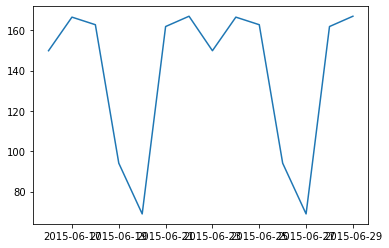

In [14]:
# timeseries forecast chart (2 weeks)
hw_array_x = hw_fcst_df[['Date']].to_numpy()
hw_array_y = hw_fcst_df[['HW Forecast (oz)']].to_numpy()
plt.plot(hw_array_x, hw_array_y)

##### Observations:
In forecating the following two weeks of lettuce demand, the Holt-Winters model is able to project for the Fridays and Saturdays that are going to have much lower consumption than the rest of the weekdays. Based on the clear observed seasonality it makes the Holt-Winters model a good candidate for our final forecast.

# Forecast for June 16th-30th 2015

In [15]:
# Create 2-week forecast results DataFrame
forecast_dates = pd.date_range(start="2015-06-16", end="2015-06-29")
forecast_results = pd.DataFrame({'Date': forecast_dates, 'ARIMA Forecast (oz)': arima_forecast,'Holt-Winters Forecast (oz)': hw_forecast}).set_index('Date')
print(forecast_results)

            ARIMA Forecast (oz)  Holt-Winters Forecast (oz)
Date                                                       
2015-06-16           148.482754                  149.840835
2015-06-17           141.767396                  166.483012
2015-06-18           140.239610                  162.727629
2015-06-19           139.892029                   94.103952
2015-06-20           139.812952                   68.958094
2015-06-21           139.794962                  161.824664
2015-06-22           139.790869                  166.925642
2015-06-23           139.789938                  149.840835
2015-06-24           139.789726                  166.483012
2015-06-25           139.789678                  162.727629
2015-06-26           139.789667                   94.103952
2015-06-27           139.789664                   68.958094
2015-06-28           139.789664                  161.824664
2015-06-29           139.789663                  166.925642


##### Observations:
Side-by-side we can observe that the ARIMA model provides a constant baseline whereas the Holt-Winters forecast provides a much better prediction with the lower or higher demand figures on a given weekday. The implication of choosing a better model for the forecast lies in saving costs by not buying too much lettuce, in guaranteeing customer satisfaction by not running out of lettuce, and in keeping the ingredient as fresh as possible. Based on these considerations, it is clear that the Holt-Winters model is the optimal forecast to accomodate for the seasonality of the weekdays.

##### Business Recommendation:
Knowing that Fridays and Saturdays has much less demand for lettuce than any other days of the week, weekly shipments could be delivered on Satuday evenings or Sunday mornings. This ensures the freshest stock for the most consumption during the week, and also leaves the least fresh lettuce for the days where there is much less consumption.

### Residual Analysis

Mean Squared Error (MSE) is a measure of the average squared difference of the actual versus predicted values. In other words, this helps us get a better idea of how well our model fits the data. Models with better fits will have lower MSEs.

In [16]:
# Get actual lettuce consumed in last two weeks aligned with days of the week occuring during 16th-29th forecast (Tuesday-Tuesday)
twowk_actuals = lettuce_data_Q2_2015.copy()
twowk_actuals  = twowk_actuals.tail(14)
twowk_actuals = twowk_actuals.drop('Day', axis=1)
twowk_actuals

# create arrays of two-week actuals/forecast for intput into residual analysis
twowk_actuals_array = np.array(twowk_actuals)
arima_forecast_array = np.array(arima_forecast)
rarima_forecast_array = np.array(rarima_forecast)
hw_forecast_array = np.array(hw_forecast)
date_array = np.array(forecast_dates)

# run for Mean Square Error estimates
arima_mse = mean_squared_error(twowk_actuals_array,arima_forecast_array)
hw_mse = mean_squared_error(twowk_actuals_array,hw_forecast_array)
rarima_mse = mean_squared_error(twowk_actuals_array,rarima_forecast_array)

print("Mean Squared Error for ARIMA: " + str(arima_mse))
print("Mean Squared Error for Holt-Winters: " + str(hw_mse))

Mean Squared Error for ARIMA: 954.875532440156
Mean Squared Error for Holt-Winters: 238.50066902974095


### Model Fit

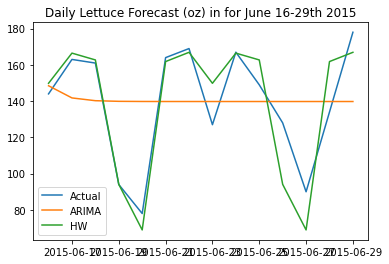

In [17]:
# plot actuals, ARIMA forecast, and Holt-Winters forecast
plt.plot(date_array, twowk_actuals_array, label = "Actual")
plt.plot(date_array, arima_forecast_array, label = "ARIMA")
plt.plot(date_array, hw_forecast_array, label = "HW")
plt.legend()
plt.title('Daily Lettuce Forecast (oz) in for June 16-29th 2015')
plt.show()

To finalize our forecast, we choose the Holt-Winters model for two reasons. First, the residual analysis suggests it is a far better fitting model than ARIMA, and second, triple exponential smoothing is the optimal method to deal with the heavy weekday seasonability of lettuce consumption. It also gives confidence in our decision after having vizualized the demand forecast on a timeseries chart and observe how the Holt-Winters predictions closely match past consumption.

### Final Forecast

In [18]:
# 2-week Forecast Table
final_forecast_df = pd.DataFrame(forecast_results['Holt-Winters Forecast (oz)'])
final_forecast_df.reset_index(inplace = True)
final_forecast_df.columns = ['Store', 'California 1 (ID:46673)']
final_forecast_df

,Store,California 1 (ID:46673)
0,2015-06-16,149.840835
1,2015-06-17,166.483012
2,2015-06-18,162.727629
3,2015-06-19,94.103952
4,2015-06-20,68.958094
5,2015-06-21,161.824664
6,2015-06-22,166.925642
7,2015-06-23,149.840835
8,2015-06-24,166.483012
9,2015-06-25,162.727629


In [19]:
# output to csv
final_forecast_df.to_csv("466732_27_forecast.csv", index=False)

-------------------------------------------------------------------------------------------------------------------------------

##### Improving the ARIMA model with revised ACF/PACF lags
In the ACF and PACF charts we noticed that the first lag cutoff is at p=1 and q=1, however, if we look past this we can see than the next noticeable lag is at 7, which matches with the days in the week. When we update our model with p=7 and q=7, we see that the revised ARIMA (rARIMA) forecast is much more accurate, where the bic model fit is much lower and the mean squared error is very close to the Holt-Winters residuals.

In [20]:
# revised ARIMA Model parameters
p, d, q = 7, 1, 7
# Estimate the ARIMA model
rarima_model = ARIMA(lettuce_array, order=(p, d, q))
# Fit the ARIMA model
rarima_result = rarima_model.fit()
print("BIC Model Fit: " + str(rarima_result.bic))
# Forecast the ARIMA model
rarima_forecast = rarima_result.forecast(steps=14)
# final df
rarima_df = pd.DataFrame({'Date':rarima_forecast.index, 'rARIMA Forecast (oz)':rarima_forecast.values})
print("rARIMA avg forecasted lettuce per day (oz): " + str (rarima_df['rARIMA Forecast (oz)'].mean()))
print("Mean Squared Error for Revised ARIMA: " + str(rarima_mse))

rarima_df

C:\Users\tsymonds\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\tsymonds\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\tsymonds\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\tsymonds\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


BIC Model Fit: 975.3148162899488
rARIMA avg forecasted lettuce per day (oz): 140.18749536544556
Mean Squared Error for Revised ARIMA: 204.59568929447957


C:\Users\tsymonds\Anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,Date,rARIMA Forecast (oz)
0,2015-06-16,154.378726
1,2015-06-17,175.516418
2,2015-06-18,165.351343
3,2015-06-19,105.513538
4,2015-06-20,74.287818
5,2015-06-21,145.336834
6,2015-06-22,162.517929
7,2015-06-23,151.116668
8,2015-06-24,175.667900
9,2015-06-25,166.998263


In [21]:
print("BIC Model Fit: " + str(rarima_result.bic))
print("rARIMA avg forecasted lettuce per day (oz): " + str (rarima_df['rARIMA Forecast (oz)'].mean()))
print("Mean Squared Error for Revised ARIMA: " + str(rarima_mse))

BIC Model Fit: 975.3148162899488
rARIMA avg forecasted lettuce per day (oz): 140.18749536544556
Mean Squared Error for Revised ARIMA: 204.59568929447957


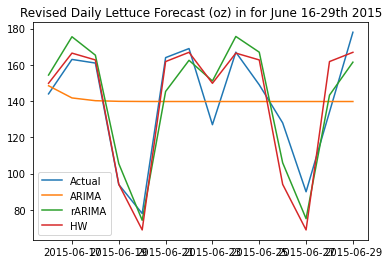

In [22]:
# plot actuals, ARIMA forecast, and Holt-Winters forecast
plt.plot(date_array, twowk_actuals_array, label = "Actual")
plt.plot(date_array, arima_forecast_array, label = "ARIMA")
plt.plot(date_array, rarima_forecast_array, label = "rARIMA")
plt.plot(date_array, hw_forecast_array, label = "HW")
plt.legend()
plt.title('Revised Daily Lettuce Forecast (oz) in for June 16-29th 2015')
plt.show()

In [23]:
# Revise 2-week forecast results DataFrame
forecast_dates = pd.date_range(start="2015-06-16", end="2015-06-29")
revised_forecast_results = pd.DataFrame({'Date': forecast_dates, 'ARIMA Forecast (oz)': arima_forecast, 'rARIMA Forecast (oz)': rarima_forecast, 'Holt-Winters Forecast (oz)': hw_forecast}).set_index('Date')
revised_forecast_results

,ARIMA Forecast (oz),rARIMA Forecast (oz),Holt-Winters Forecast (oz)
Date,,,
2015-06-16,148.482754,154.378726,149.840835
2015-06-17,141.767396,175.516418,166.483012
2015-06-18,140.239610,165.351343,162.727629
2015-06-19,139.892029,105.513538,94.103952
2015-06-20,139.812952,74.287818,68.958094
2015-06-21,139.794962,145.336834,161.824664
2015-06-22,139.790869,162.517929,166.925642
2015-06-23,139.789938,151.116668,149.840835
2015-06-24,139.789726,175.667900,166.483012


In [24]:
# output to csv
revised_forecast_results.to_csv("466732_27_forecast_revised.csv", index=False)

-------------------------------------------------------------------------------------------------------------------------------

In [25]:
from IPython.core.display import HTML
HTML("""
<style>
div.output_stderr {
    background: #028940;
}
</style>
""")